In [1]:
## Imports

## Main Code
# We will use the feature_handler class to extract features from the point clouds
from blobBgone.featureHandler import featureHandler
from blobBgone.utils import pyDialogue as pD
## MISC
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
## We will have a seriously unbalanced dataset due to the nature of the data collection
# Blobs are rather on the rare side (luckily) but will nevertheless appear in ANY SPT dataset
# Due to this, we have a significantly higher number of non-blob points than blob points.

## With the following flag, you can turn on/off the equalization of the class counts.
# Such, we guarantee intuitive comparison of feature distributions and performance metrics.
# As we don't care about labels here, we will randomly sample the datasets naively.

equalize_classes = True

In [3]:
## Grab blob and track files
# We will use the blob and track files from the example data to explore the distribution of non-standardized feature values
# We use a modified version of the static built-in function to grab the files
# This method returns a list of all the files in the current directory that end with .npy

# If you are on Windows, you can leave the path argument as None to automatically call the explorer

def grab_specific_files(path:str = None, key:str = '3D_P'):
    if path == None:
        try:
            path = pD.askDIR()
        except:
            path = input("Please enter the path to the point clouds: ")
            
    assert os.path.exists(path), "Path does not exist"
    assert os.path.isdir(path), "Path must be a directory"
    
    return np.array(glob.glob(os.path.join(path, f"{key}*.npy")))

blobs = grab_specific_files(path = "Example_Data/Additional_MFX_Data/Labelled_Data/blob/", key = 'blob')
tracks = grab_specific_files(path = "Example_Data/Additional_MFX_Data/Labelled_Data/free/", key = 'free')

if equalize_classes:
    min_length = min(len(blobs), len(tracks))
    
    gen = np.random.Generator(np.random.PCG64(42)) # This is the same seed as used in the MFX_data_Example notebook to ensure consistency between those two.
    blobs = blobs[gen.choice(len(blobs), size=min_length, replace=False).astype(int)]
    tracks = tracks[gen.choice(len(tracks), size=min_length, replace=False).astype(int)]

print(f"Found {len(blobs)} blob files in the '{blobs[0].split(os.sep)[-2]}' directory.")
print(f"Found {len(tracks)} track files in the '{tracks[0].split(os.sep)[-2]}' directory.")


# Check on length of tracks and blobs
sorted_track_len = sorted([np.load(track).__len__() for track in tracks])
sorted_blob_len = sorted([np.load(blob).__len__() for blob in blobs])

print()
print(f"Track lengths range from {sorted_track_len[0]} to {sorted_track_len[-1]}")
print(f"Blob lengths range from {sorted_blob_len[0]} to {sorted_blob_len[-1]}")

Found 107 blob files in the 'Example_Data/Additional_MFX_Data/Labelled_Data/blob' directory.
Found 107 track files in the 'Example_Data/Additional_MFX_Data/Labelled_Data/free' directory.

Track lengths range from 501 to 4054
Blob lengths range from 505 to 4683


In [4]:
## Setup the task lists
# We will use the task list to keep track of the files that have been processed
# Each feature handler is designed to handle one point cloud at a time for flexibility

blob_list = [featureHandler.from_npy(path = blob_file, verbose = False) for blob_file in blobs]
track_list = [featureHandler.from_npy(path = track_file, verbose = False) for track_file in tracks]

In [5]:
## Featre extraction
# Now that we have everything in place, we can extract the features from the point clouds
# We will use the feature_handler class to extract the features from the point clouds by calling the extract() method

blob_features = []
for task in blob_list:
    task.extract()
    blob_features.append(task.to_array())
    
track_features = []
for task in track_list:
    task.extract()
    track_features.append(task.to_array())

In [6]:
# Usually, we would transform all feature axes to the same scale/distribution to similarize their influence on the clustering performance.
# In the following, we will demonstrate how the transformation affects the distributions used for clustering.

## SETUP STANRADIZED SET
method:str = 'standardize'
standard_blob_features = featureHandler.regularize_output(blob_features, method = method)
assert np.all(np.isfinite(standard_blob_features)), "NaN values still present in features."

standard_track_features = featureHandler.regularize_output(track_features, method = method)
assert np.all(np.isfinite(standard_track_features)), "NaN values still present in features."

## SETUP NORMALIZED SET
method:str = 'normalize'
normal_blob_features = featureHandler.regularize_output(blob_features, method = method)
assert np.all(np.isfinite(normal_blob_features)), "NaN values still present in features."

normal_track_features = featureHandler.regularize_output(track_features, method = method)
assert np.all(np.isfinite(normal_track_features)), "NaN values still present in features."

Text(0, 0.5, 'Counts [a.u.]')

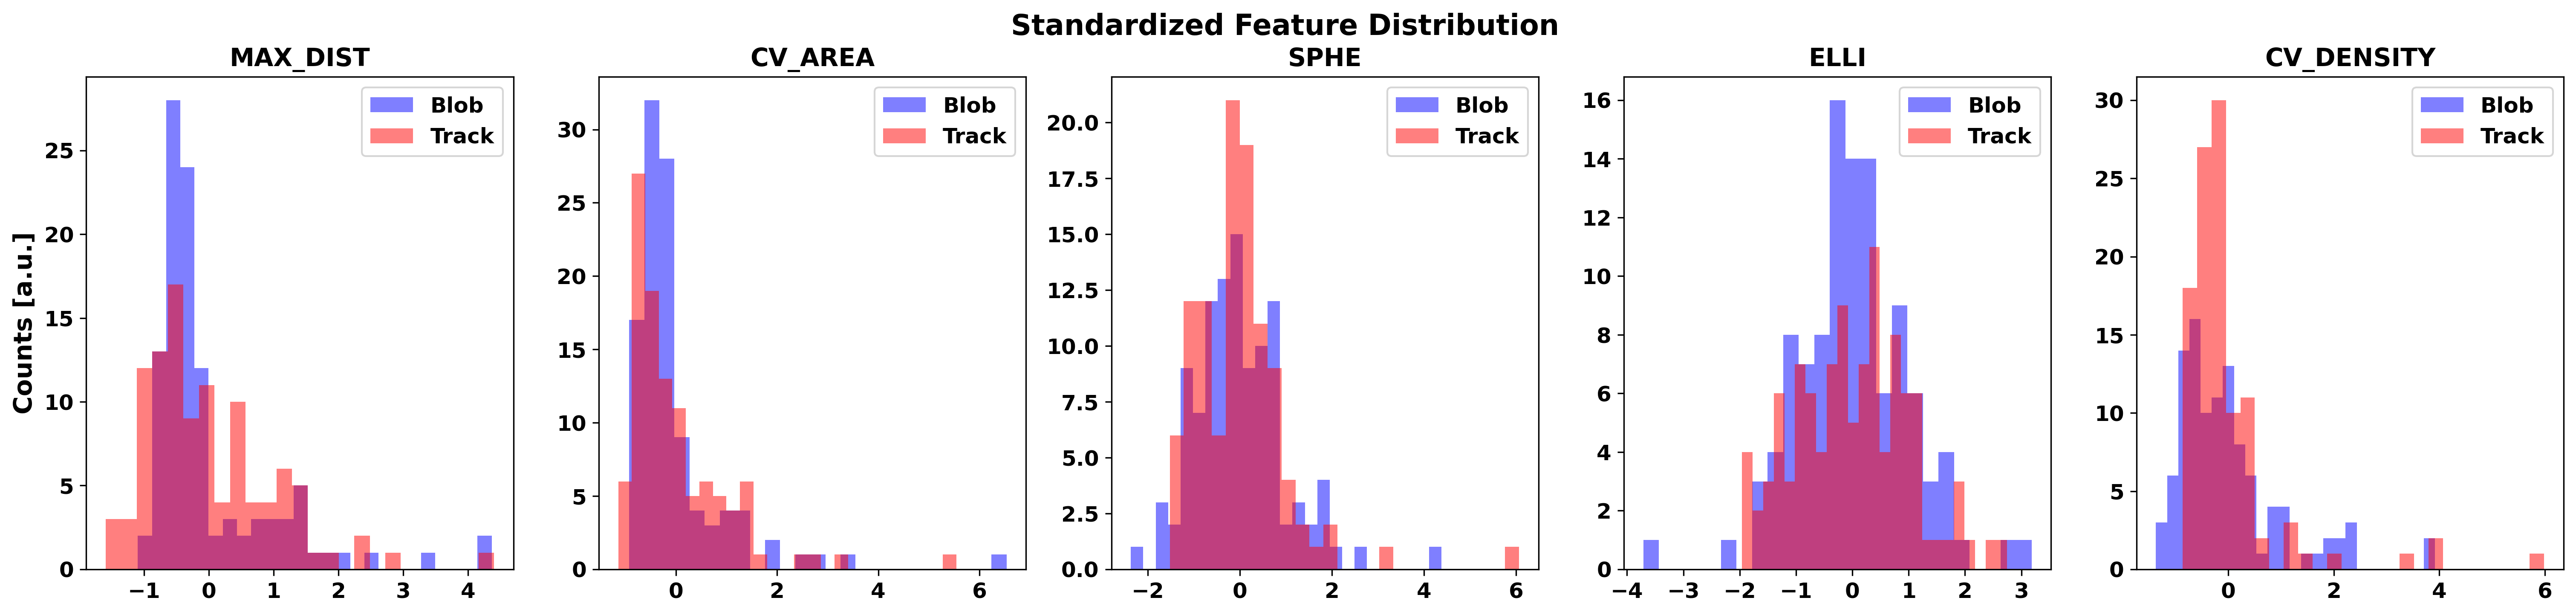

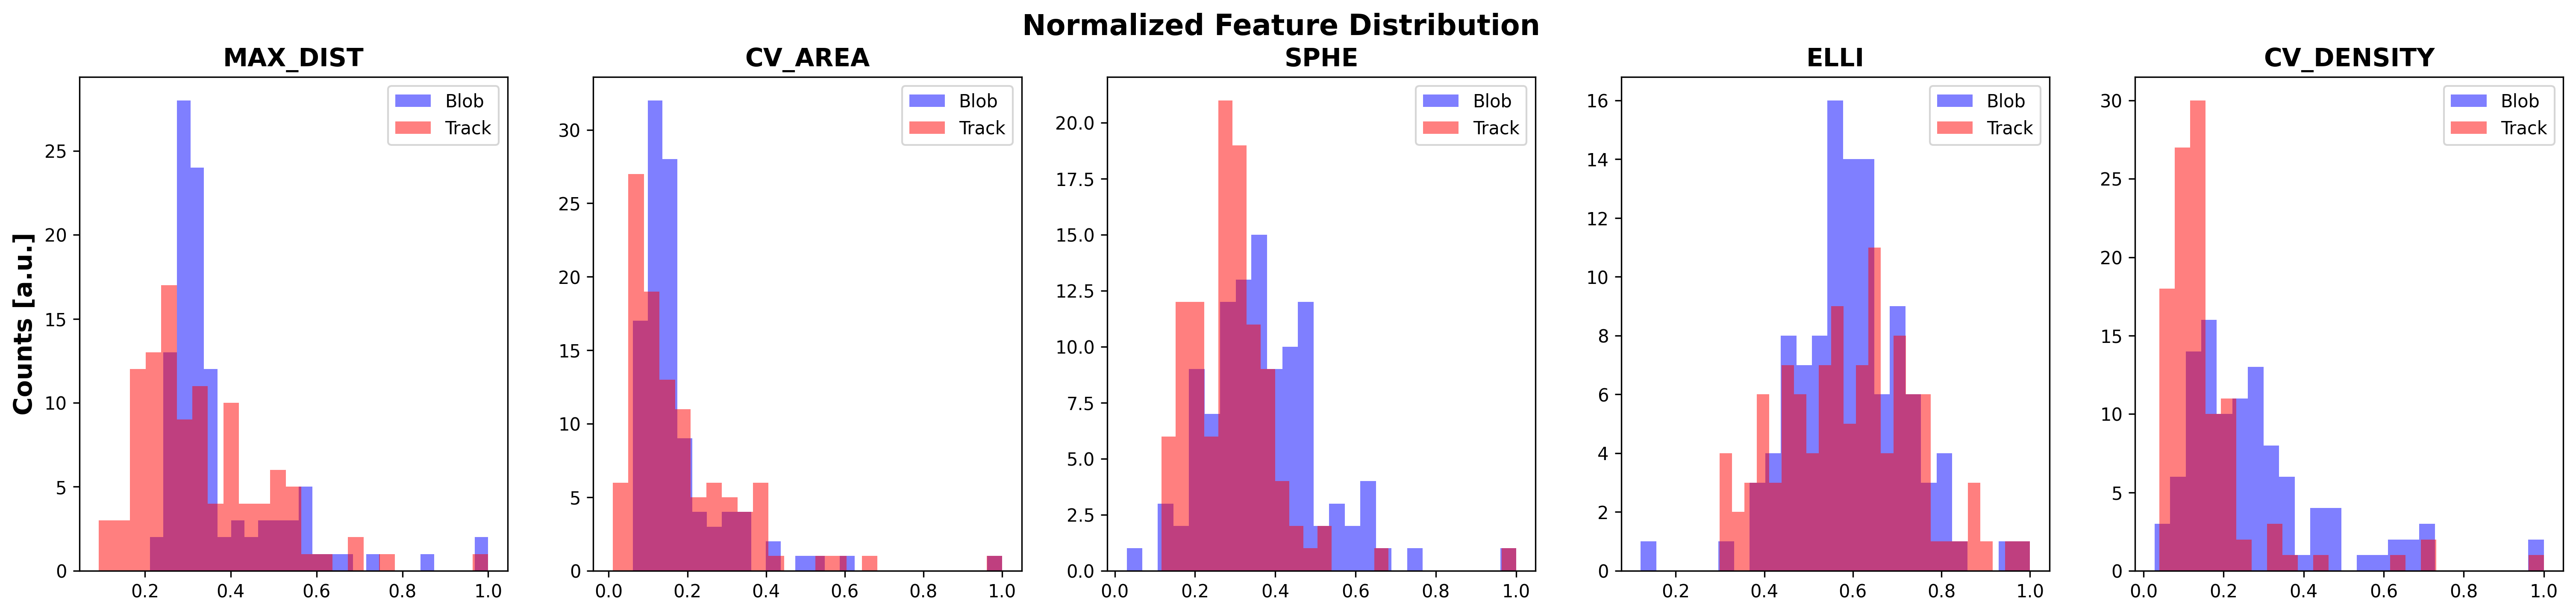

In [7]:
## We plot the standardized festure distributions fro blobs and tracks grouped by their feature type

plt.style.use('default')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# blobs
fig, axs = plt.subplots(1, 5, figsize = (25, 5), dpi = 300)
comb_standard_blob_features = np.row_stack(standard_blob_features)
comb_standard_track_features = np.row_stack(standard_track_features)

for i, desc in enumerate(list(blob_list[0].to_dict().keys())):
    axs[i].hist(comb_standard_blob_features[:,i], alpha = 0.5, bins = 25, label = 'Blob', color = 'blue')
    axs[i].hist(comb_standard_track_features[:,i], alpha = 0.5, bins = 25, label = 'Track', color = 'red')
    axs[i].set_title(desc, fontsize = 14, fontweight = 'bold')
    axs[i].legend()

fig.suptitle('Standardized Feature Distribution', fontsize = 16, fontweight = 'bold')
axs[0].set_ylabel('Counts [a.u.]', fontsize = 14, fontweight = 'bold')

## We plot the standardized festure distributions fro blobs and tracks grouped by their feature type
# In comparison, the separation of feature distributions especially for the idealized application to simulation is much more pronounced
# When aplied to real-world MINFLUX data the distributions are much more similar, still more distinguishable than with standardization

# For our method however, we will use standardized feature distributions as we care about their composition and not their absolute values
# When using standardized features, the overlap between the distributions is much more pronounced and the features are more similar in their values
# This is advantageous for clustering as no single feature will be able to dominate the clustering process

## Let us first plot all features separately as histograms for both blobs and tracks to gain an overview

plt.style.use('default')

# blobs
fig, axs = plt.subplots(1, 5, figsize = (25, 5), dpi = 300)
comb_normal_blob_features = np.row_stack(normal_blob_features)
comb_normal_track_features = np.row_stack(normal_track_features)

for i, desc in enumerate(list(blob_list[0].to_dict().keys())):
    axs[i].hist(comb_normal_blob_features[:,i], alpha = 0.5, bins = 25, label = 'Blob', color = 'blue')
    axs[i].hist(comb_normal_track_features[:,i], alpha = 0.5, bins = 25, label = 'Track', color = 'red')
    axs[i].set_title(desc, fontsize = 14, fontweight = 'bold')
    axs[i].legend()

fig.suptitle('Normalized Feature Distribution', fontsize = 16, fontweight = 'bold')
axs[0].set_ylabel('Counts [a.u.]', fontsize = 14, fontweight = 'bold')

In [8]:
## Let us now take a look at the correlation matrices
# We will use the seaborn library to plot the correlation matrices for both blobs and tracks
# Since correlation is not affected by the scaling of the features, we will use the standardized features for this plot for consitency

feature_keys = list(blob_list[0].to_dict().keys())

In [39]:
def correlation_heatmaps(blob_features, track_features, feature_keywords:list):
    ## Set up the figure
    fig, axs = plt.subplots(1,2, figsize = (28,10), dpi = 300)
    axs[0].set_title('Blob Feature Correlation Matrix - Balanced Set', fontweight = 'bold', fontsize = 18)
    axs[1].set_title('Track Feature Correlation Matrix - Balanced Set', fontweight = 'bold', fontsize = 18)

    ## Calculate the correlation matrices
    corr_blob = pd.DataFrame(blob_features, columns = feature_keywords).corr()
    corr_track = pd.DataFrame(track_features, columns = feature_keywords).corr()

    ## Find the min and max values for the colorbar
    v_min = min(*corr_blob.min(), *corr_track.min())
    v_max = max(*corr_blob.max(), *corr_track.max())

    ## Plot the correlation matrices as heatmaps
    hm1 = sns.heatmap(corr_blob, 
                cmap="RdBu", annot=True, ax = axs[0], linewidths=0.5, linecolor='black', vmin=v_min, vmax=v_max, annot_kws={"size": 14, 'weight': 'bold'})
    hm2 = sns.heatmap(corr_track, 
                cmap="RdBu", annot=True, ax = axs[1], linewidths=0.5, linecolor='black', vmin=v_min, vmax=v_max, annot_kws={"size": 14, 'weight': 'bold'})


    ## Adjust axis fontsize
    for ax in axs:
        for tick_x, tick_y in zip(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
            tick_x.label1.set_fontsize(14) 
            tick_y.label1.set_fontsize(14)
            tick_x.label1.set_fontweight('bold') 
            tick_y.label1.set_fontweight('bold') 
            tick_y.label1.set_rotation(45)

    ## Adjust Colorbar fontsize
    hm1.cb = hm1.collections[0].colorbar
    for t in hm1.cb.ax.get_yticklabels():
        t.set_fontsize(16)
        t.set_fontweight('bold')

    hm2.cb = hm2.collections[0].colorbar
    for t in hm2.cb.ax.get_yticklabels():
        t.set_fontsize(16)
        t.set_fontweight('bold')
    
    return fig, axs, v_max, v_min

In [40]:
def correlation_clustermap(features, feature_keywords:list, title:str = None, v_max = 1, v_min = -1):
    ## Calculate the correlation matrices
    corr_blob = pd.DataFrame(features, columns = feature_keywords).corr()
    
    ## Plot the correlation matrices as heatmaps
    cm1 = sns.clustermap(corr_blob,
                         method = 'complete',
                         cmap   = 'RdBu', 
                         annot  = True, 
                         linewidths=0.75, linecolor='black',
                         dendrogram_ratio=0.15, tree_kws={'linewidth': 5},
                         annot_kws={"size": 16, 'weight': 'bold'},
                         vmax = v_max, vmin = v_min)

    cm1.ax_heatmap.set_yticklabels(cm1.ax_heatmap.get_yticklabels(), rotation = -45, fontsize = 16, fontweight = 'bold')
    cm1.ax_heatmap.set_xticklabels(cm1.ax_heatmap.get_xticklabels(), rotation = 0, fontsize = 16, fontweight = 'bold')
        
    cb = cm1.ax_heatmap.collections[0].colorbar
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(16)
        t.set_fontweight('bold')
    
    if title:
        plt.title(title, fontweight = 'bold', fontsize = 18, loc="left", pad=25)
    
    return cm1

In [60]:
def calculate_PCA_eigenvectors(feature_set_list:list, n_components:int = 3, absolute:bool = True):
    ## A Function to calculate the eigenvectors of the PCA for a list of features and return both eigenvectors and explained variance ratios
    
    PCA_list = [PCA(n_components=n_components) for _ in range(len(feature_set_list))]
    [pca.fit_transform(feature_set) for pca, feature_set in zip(PCA_list, feature_set_list)]

    if absolute:
        return [abs(pca.components_) for pca in PCA_list], [pca.explained_variance_ratio_.round(2) for pca in PCA_list]
    else:
        return [pca.components_ for pca in PCA_list], [pca.explained_variance_ratio_.round(2) for pca in PCA_list]
    
def plot_PCA_eigenvectors(feature_set_list, title_list:list, n_components:int = 3, absolute:bool = True):
    PCA_components, PCA_ratios = calculate_PCA_eigenvectors(feature_set_list, n_components = n_components, absolute = absolute)
    PCA_components_dict = {key:(pca_eigenvector, pca_ratio)for key, pca_eigenvector, pca_ratio in zip(title_list, PCA_components, PCA_ratios)}


    for key in PCA_components_dict.keys():
        temp_df = pd.DataFrame.from_dict(PCA_components_dict[key][0])
        temp_df.columns = list(blob_list[0].to_dict().keys())
        temp_df.index = [f"PC{i+1} - EVR: {PCA_components_dict[key][1][i]:.2f}" for i in range(n_components)]
        temp_df = temp_df.T
        
        ## Plot the eigenvectors
        plt.style.use('default')

        font = {'family' : 'DejaVu Sans',
                'weight' : 'bold',
                'size'   : 14}

        plt.rc('font', **font)
        
        fig, ax = plt.subplots(1,1,dpi = 300, figsize = (3,3))
        temp_df.T.plot(kind = 'bar', figsize = (5,5), title = f'PCA Eigenvectors for\n{key}\n', ylim = (-1,1), ax=ax)
        
        if absolute:
            ax.set_ylim(0,1)   
                 
        plt.hlines(0,-1,5, color = 'k', linestyle = '--')
        plt.setp(ax.get_xticklabels(), rotation=0)
        plt.legend(loc = 'lower right', fontsize = 12)
        
    return fig, ax

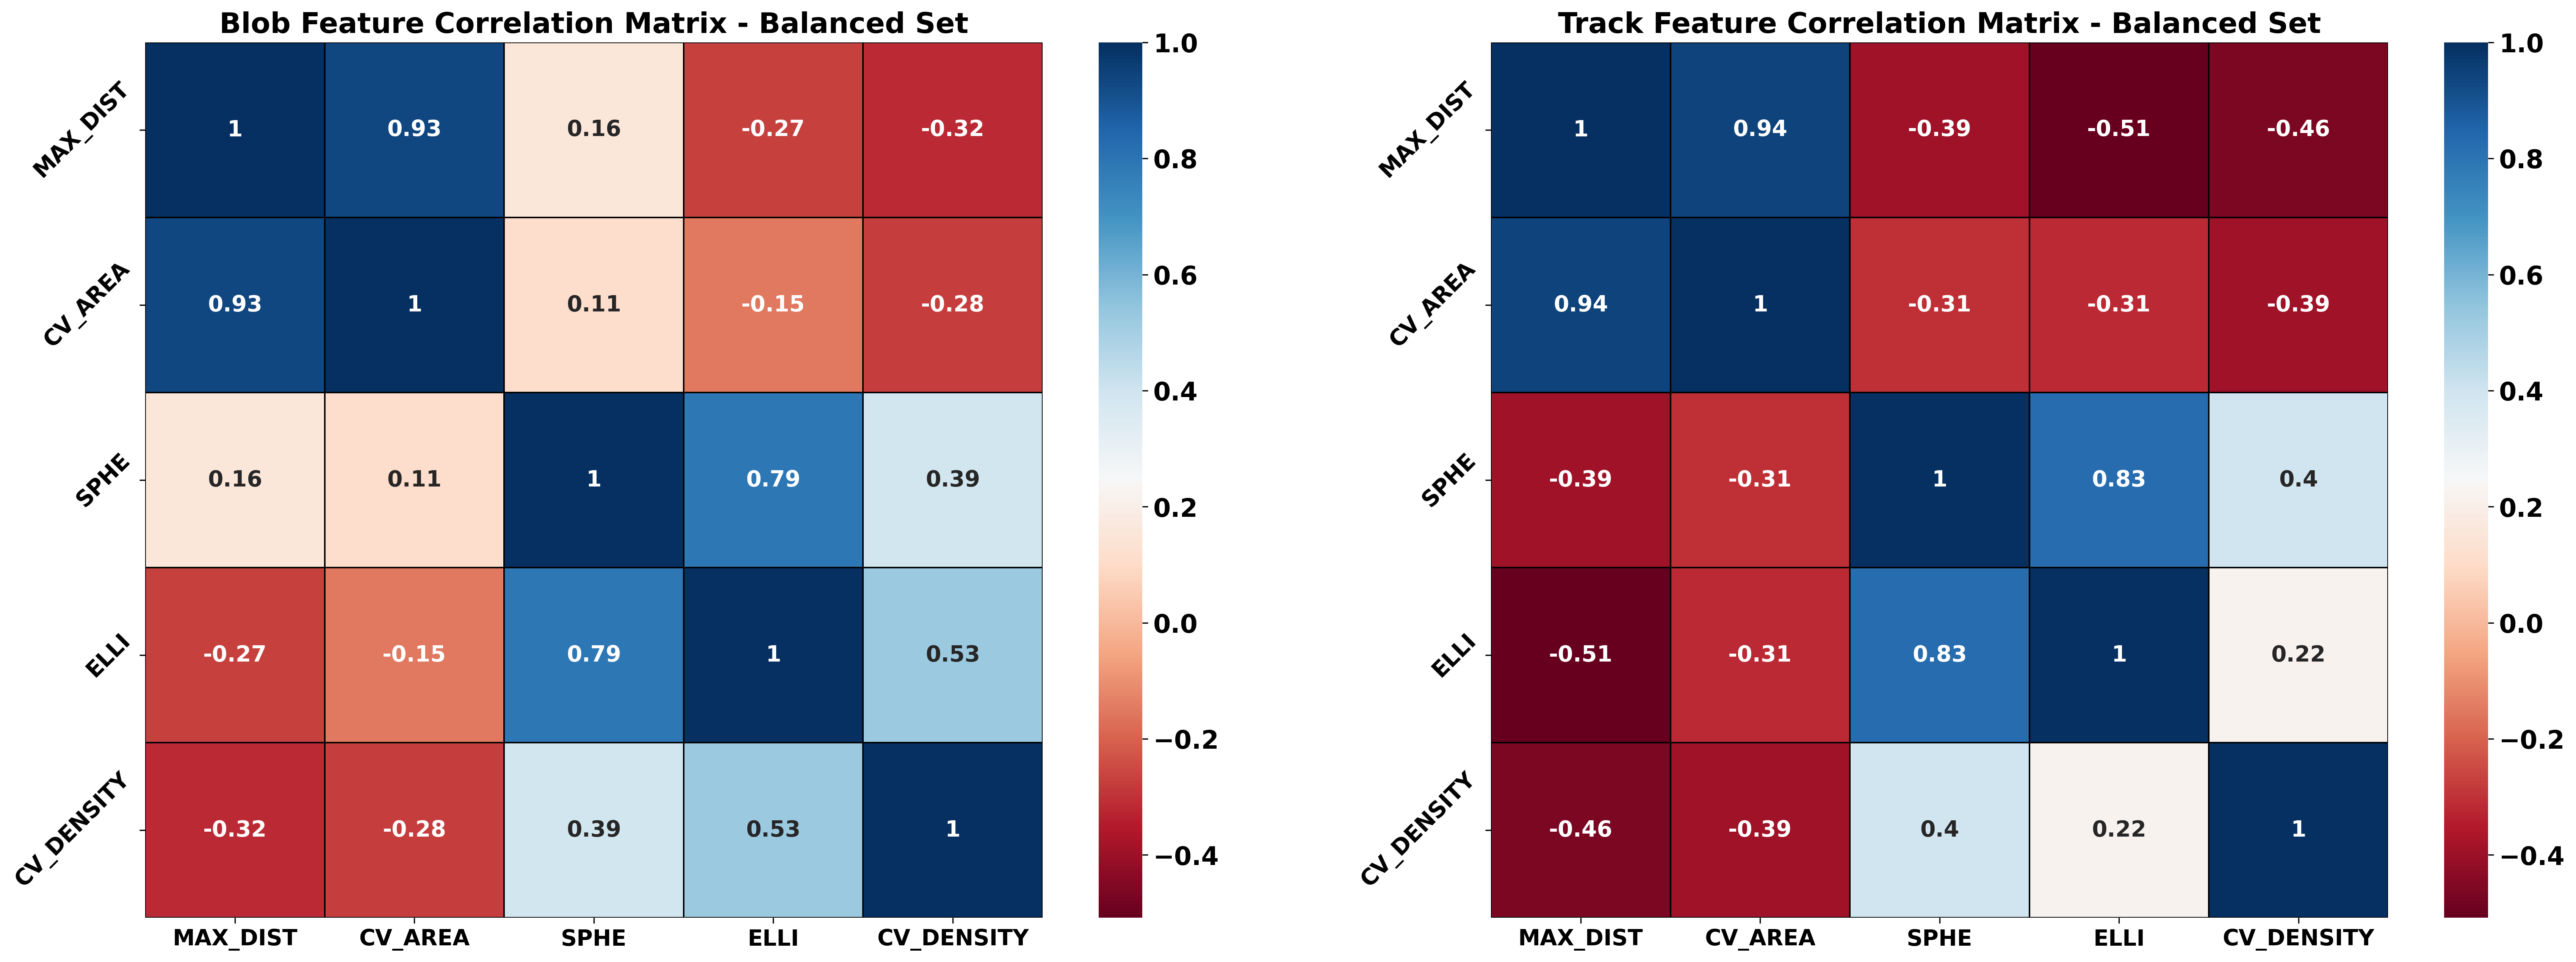

In [42]:
fig, axs, v_max, v_min = correlation_heatmaps(comb_standard_blob_features, comb_standard_track_features, feature_keys)

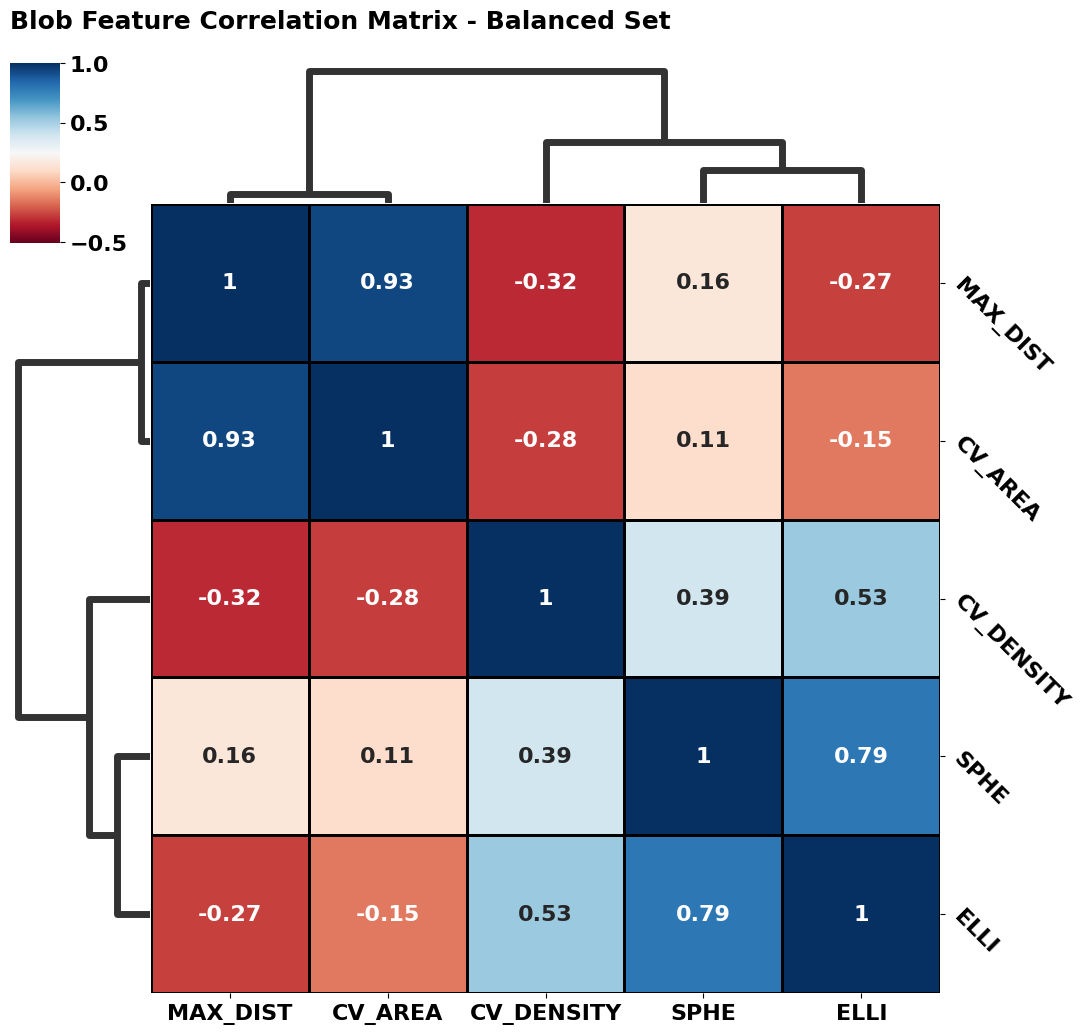

In [43]:
cm = correlation_clustermap(comb_standard_blob_features, feature_keys, title='Blob Feature Correlation Matrix - Balanced Set', v_max = v_max, v_min = v_min)

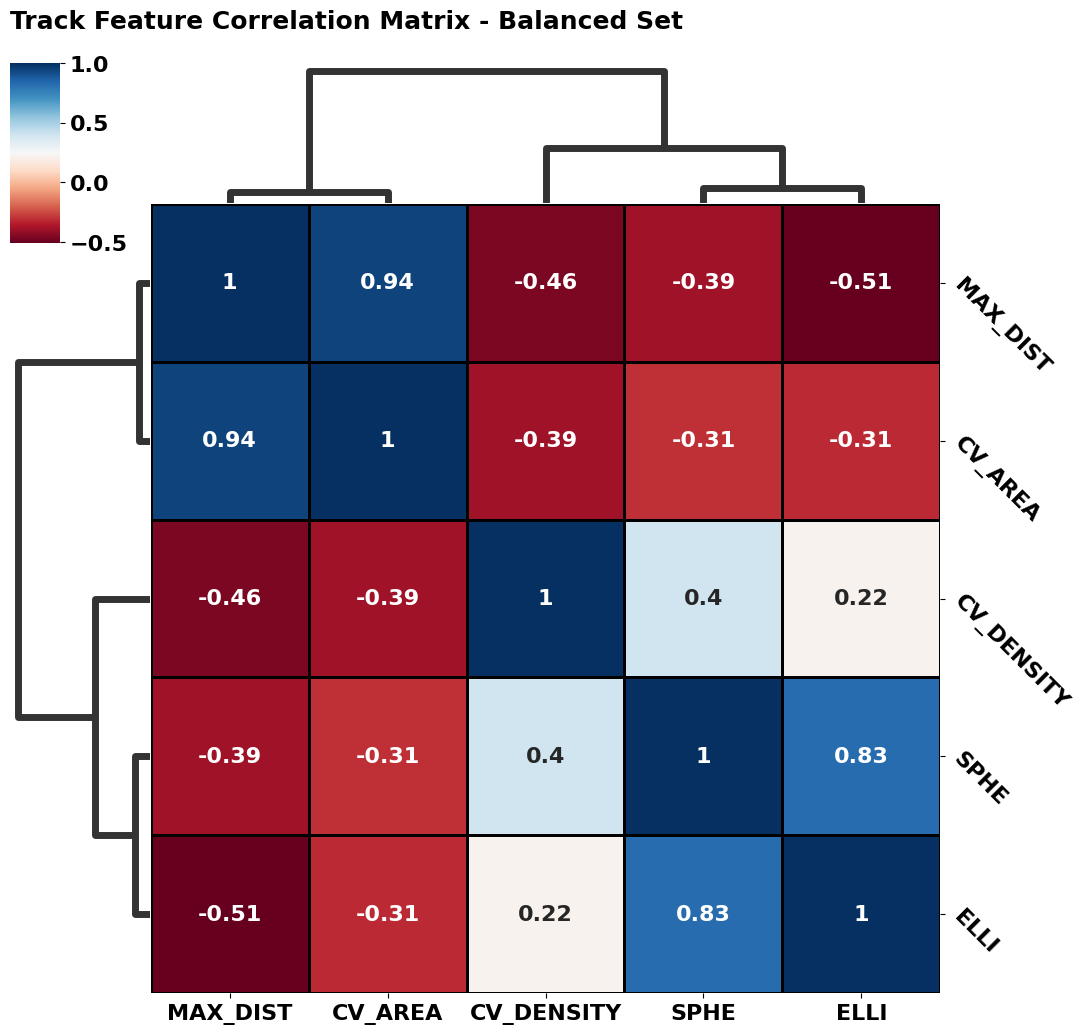

In [44]:
cm = correlation_clustermap(comb_standard_track_features, feature_keys, title='Track Feature Correlation Matrix - Balanced Set', v_min=v_min, v_max=v_max)

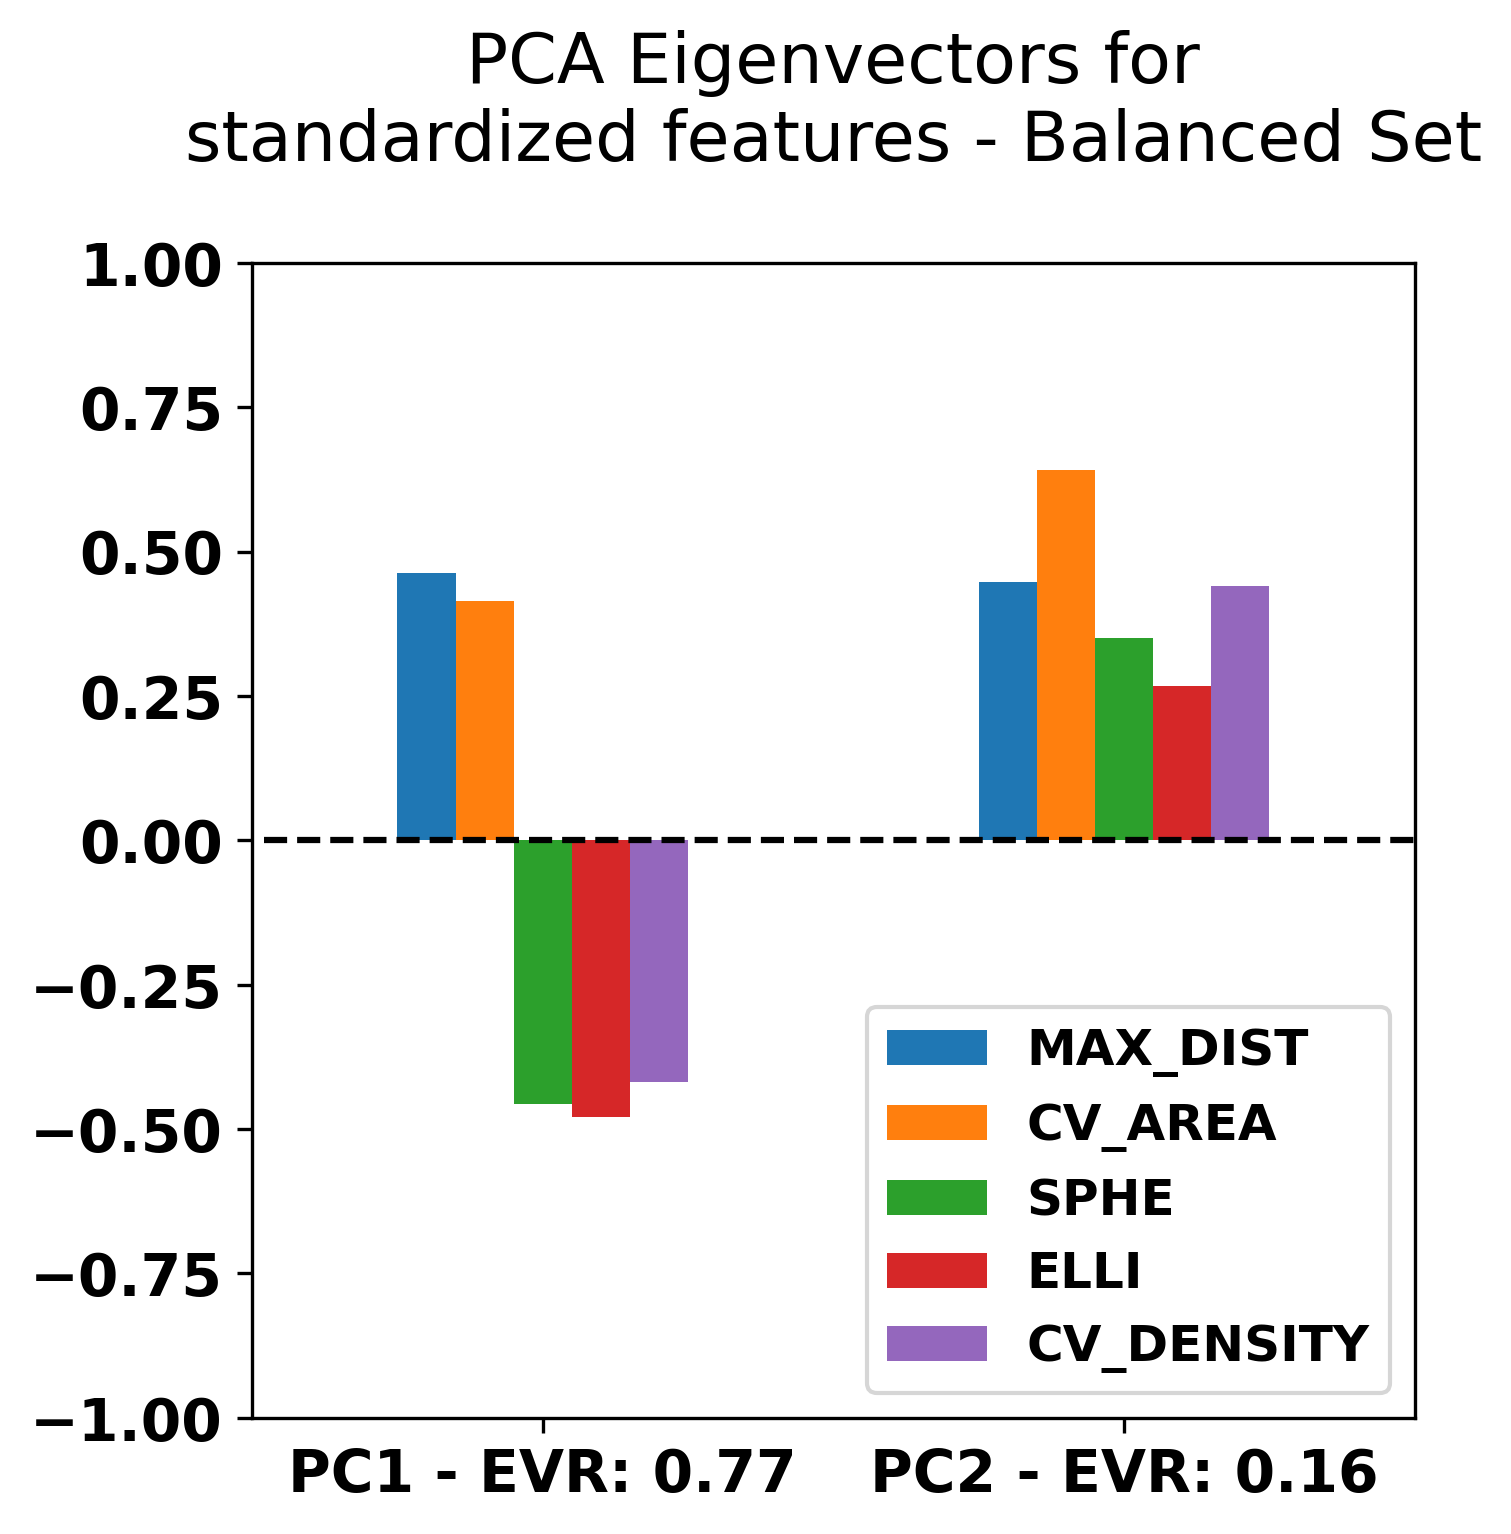

In [61]:
## Generate fill feature list
features = []
for task in blob_list+track_list:
    task.extract()
    features.append(task.to_array())
features = featureHandler.regularize_output(features, method = 'standardize')
assert np.all(np.isfinite(features)), "NaN values still present in features."

fig, ax = plot_PCA_eigenvectors([features], ["standardized features - Balanced Set"], n_components = 2, absolute = False)